# To reproduce a run and investigate seasonal transition signature

In [75]:
# Import libraries
import os
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

sys.path.append("../libs/cfe_py")
from bmi_cfe import BMI_CFE

sys.path.append("../libs/SMSig")
from sig_seasontrans import SMSig

# Specify current directory create output directory if it does not exist
os.getcwd()

'g:\\Shared drives\\Ryoko and Hilary\\SMSigxModel\\analysis\\5_post_analysis'

# Configuration

In [76]:
site = "Mahurangi"
case = rf"{site}-2024-03-22"


In [77]:
data_directory = rf"..\data\{site}"
config_temp_path = os.path.join(data_directory, "temporary_parameter_files_for_GLUE", "config_cfe_0.json")
prior_params_path = rf"..\3_GLUE_prerun\results\{case}\prior_parameters.csv"
evaluation_metrics_path = rf"..\3_GLUE_prerun\results\{case}\evaluation_metrics.csv"
out_path = rf".\results\{case}"
if not os.path.exists(out_path):
    os.makedirs(out_path)

# Load parameters for a run

In [78]:
eval_metrics = pd.read_csv(evaluation_metrics_path)
# eval_metrics[(eval_metrics['KGE on Soil']>0.71) & (eval_metrics['SeasonTrans of Soil dry2wet_end']>50)]
# 93, 32, 71
# eval_metrics[(eval_metrics['SeasonTrans of Soil wet2dry_start']<50)]
thresh = 50
subset = eval_metrics[(eval_metrics['SeasonTrans of Soil dry2wet_end']>=30)&(eval_metrics['KGE on Soil']>=0.5)&(eval_metrics['KGE on Flow']>=0.5)]
# subset = eval_metrics[(eval_metrics['SeasonTrans of Soil dry2wet_start']<=thresh) & (eval_metrics['SeasonTrans of Soil wet2dry_start']<=thresh)& (eval_metrics['SeasonTrans of Soil dry2wet_end']<=thresh) & (eval_metrics['SeasonTrans of Soil wet2dry_end']<=thresh)]
len(subset)
subset
# eval_metrics[(eval_metrics['KGE on Soil']>0.5)]
# run_id=190
# eval_metrics[(eval_metrics['KGE on Soil']>0.7) & (eval_metrics['SeasonTrans of Soil dry2wet_end']>50)]
# run_id=113, 9817

,run_id,NSE on Flow,NSE on Soil,KGE on Flow,KGE on Soil,SeasonTrans of Soil dry2wet_start,SeasonTrans of Soil dry2wet_end,SeasonTrans of Soil wet2dry_start,SeasonTrans of Soil wet2dry_end,SeasonTrans of Soil dry2wet_start_raw,SeasonTrans of Soil dry2wet_end_raw,SeasonTrans of Soil wet2dry_start_raw,SeasonTrans of Soil wet2dry_end_raw
0,0,0.870583,-0.116197,0.879833,0.723320,0.898833,32.207192,0.077867,1.788701,"[15.947310891002417, 5.507696024607867, -18.75...","[-62.58391141379252, -14.955658408813179, -19....","[3.553183412645012, 5.564178702421486, -9.3509...","[2.839305623434484, -7.19964348943904, -1.0057..."
2,2,0.742028,-1.650655,0.783288,0.794262,2.027438,30.647320,0.391725,8.624781,"[18.15436767693609, 6.544598508160561, -18.616...","[-60.39012540364638, -10.609820154961199, -20....","[3.6848616492934525, 4.674633755348623, -7.184...","[17.2484363601543, 1.0754332607612014, 7.55047..."
3,3,0.869110,0.677258,0.873533,0.816237,2.029368,30.500882,0.682203,4.121407,"[17.889151433017105, 6.2895186031237245, -18.0...","[-60.24108660873026, -11.23238810757175, -20.0...","[4.616347371600568, 5.564206396695226, -8.1339...","[7.981033302843571, -2.0500190486200154, 6.433..."
8,8,0.885191,-4.261676,0.928568,0.722329,1.849483,31.057671,0.523363,4.541894,"[17.838114033453166, 6.32675442006439, -18.616...","[-61.07726392429322, -11.934030384290963, -20....","[4.253570530563593, 5.308746501337737, -7.9922...","[10.33319292915985, -1.974857181776315, 5.2673..."
17,17,0.882955,-4.877437,0.924068,0.571807,0.565337,33.849636,1.199297,9.798470,"[13.965511611662805, 3.595277273096144, -19.25...","[-67.05157552473247, -16.8719825418666, -17.62...","[1.621203560847789, 5.341705149039626, -10.560...","[-3.9856243222020566, -13.95283358823508, -11...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99955,99955,0.890852,0.612460,0.941434,0.680467,0.296435,32.793941,0.605464,5.933334,"[14.989300408400595, 4.516259068623185, -18.61...","[-64.13921581488103, -15.624196171294898, -18....","[2.583358021453023, 5.684025500435382, -10.083...","[-0.7197941774502397, -10.947652461472899, -6...."
99960,99960,0.695280,0.783925,0.819324,0.779248,0.532305,33.710736,0.033712,0.085727,"[16.06927907979116, 5.53502133442089, -20.0073...","[-65.03683696920052, -15.081979394424707, -21....","[4.493832657579333, 3.8626035172492266, -8.255...","[6.937573850620538, -4.055563902948052, -2.624..."
99961,99961,0.875079,-1.733835,0.899162,0.588455,0.741014,33.765892,1.422038,10.970940,"[13.802056655753404, 3.343219622503966, -19.36...","[-67.40213561663404, -17.13209319394082, -16.7...","[1.2219244977459311, 5.410779705736786, -10.89...","[-5.209377272520214, -15.025435004383326, -12...."
99973,99973,0.822455,-11.047938,0.787673,0.561321,0.364515,32.585363,0.416656,4.386820,"[15.069147603586316, 4.771073539741337, -18.74...","[-63.538936478085816, -15.411490950267762, -18...","[3.0096272863447666, 5.56417719181627, -9.8237...","[0.677148980088532, -9.384943880606443, -4.452..."


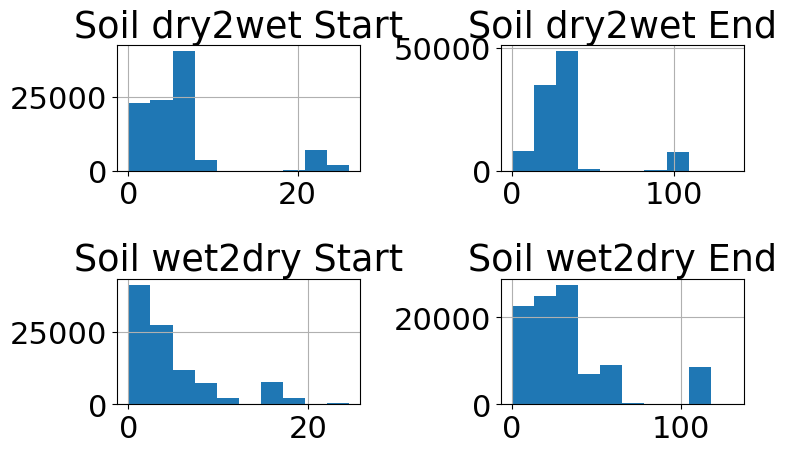

In [79]:
# Creating 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# Plotting each histogram
eval_metrics['SeasonTrans of Soil dry2wet_start'].hist(ax=axs[0, 0])
axs[0, 0].set_title('Soil dry2wet Start')

eval_metrics['SeasonTrans of Soil dry2wet_end'].hist(ax=axs[0, 1])
axs[0, 1].set_title('Soil dry2wet End')

eval_metrics['SeasonTrans of Soil wet2dry_start'].hist(ax=axs[1, 0])
axs[1, 0].set_title('Soil wet2dry Start')

eval_metrics['SeasonTrans of Soil wet2dry_end'].hist(ax=axs[1, 1])
axs[1, 1].set_title('Soil wet2dry End')

plt.tight_layout()
plt.show()

In [80]:
config_all_runs = pd.read_csv(prior_params_path)
config_all_runs.head()

,run_id,bb,satdk,slop,smcmax,wltsmc,max_gw_storage,expon
0,0,15.241602,0.003717,0.305407,0.511144,0.303985,0.143744,2.829918
1,1,9.591115,0.009610,0.288152,0.431847,0.337942,0.134378,4.848366
2,2,8.110328,0.003576,0.073707,0.564340,0.250904,0.166409,7.468712
3,3,15.606284,0.008876,0.088979,0.540960,0.311782,0.158104,3.165957
4,4,4.477468,0.005622,0.134352,0.402397,0.273392,0.175923,2.118343


In [81]:

run_id =99955
config_target_runs = config_all_runs[config_all_runs["run_id"]==run_id]
print(config_target_runs)

       run_id         bb     satdk     slop    smcmax    wltsmc  \
99955   99955  18.791981  0.011038  0.31227  0.519456  0.337661   

       max_gw_storage     expon  
99955        0.169649  5.185697  


In [82]:
with open(config_temp_path, 'r') as outfile:
    config_temp = json.load(outfile)

In [83]:
for key, value in config_target_runs.items():
    if key == "run_id":
        None
    elif key in ['bb', 'satdk', 'slop', 'satpsi', 'smcmax', 'wltsmc', 'D']:
        config_temp["soil_params"][key] = value.values[0]
    else:
        config_temp[key] = value.values[0]
config_temp

{'forcing_file': 'G:/Shared drives/Ryoko and Hilary/SMSigxModel/analysis/data/Mahurangi/forcing_daily_1998_2001.csv',
 'catchment_area_km2': 46.65,
 'soil_params': {'bb': 18.79198110863063,
  'satdk': 0.0110379723398209,
  'slop': 0.3122704560254826,
  'smcmax': 0.519455662364086,
  'wltsmc': 0.3376613569970695,
  'satpsi': 0.263,
  'D': 1},
 'max_gw_storage': 0.1696486839236229,
 'Cgw': 0.0018,
 'expon': 5.185696656882486,
 'K_lf': 0.892110561724,
 'K_nash': 0.269168149445,
 'num_nash_storage': 2,
 'giuh_ordinates': [0.5, 0.5],
 'trigger_z_fact': 0.424510757139,
 'alpha_fc': 0.33,
 'refkdt': 3,
 'time_step_size': 86400,
 'stand_alone': 1,
 'unit_test': 1,
 'compare_results_file': 'G:/Shared drives/Ryoko and Hilary/SMSigxModel/analysis/data/Mahurangi/test_daily_1998_2001_sm_basinavg.csv'}

In [84]:
temporary_config_path = "temporary_config_reproducing_run"
if not os.path.exists(temporary_config_path):
    os.makedirs(temporary_config_path)

In [85]:
temporary_config_file = os.path.join(temporary_config_path, f"config_cfe_{run_id}.json")
with open(temporary_config_file, 'w') as out_file:
    json.dump(config_temp, out_file)

# Run CFE

GW & SM converged <1% after warm-up iteration 1; diff_gw: 0.0000000; diff_sm: 0.0000000


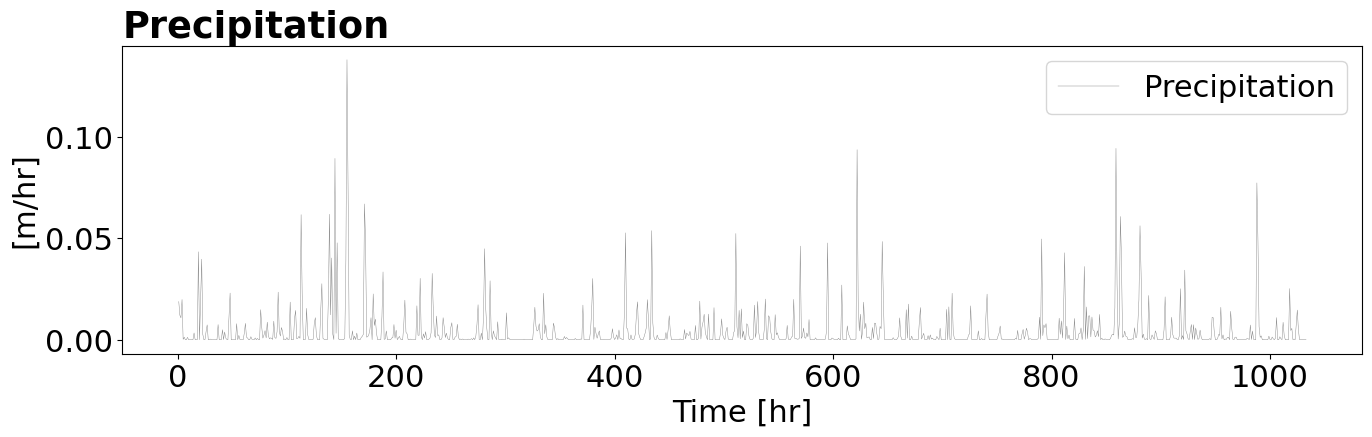

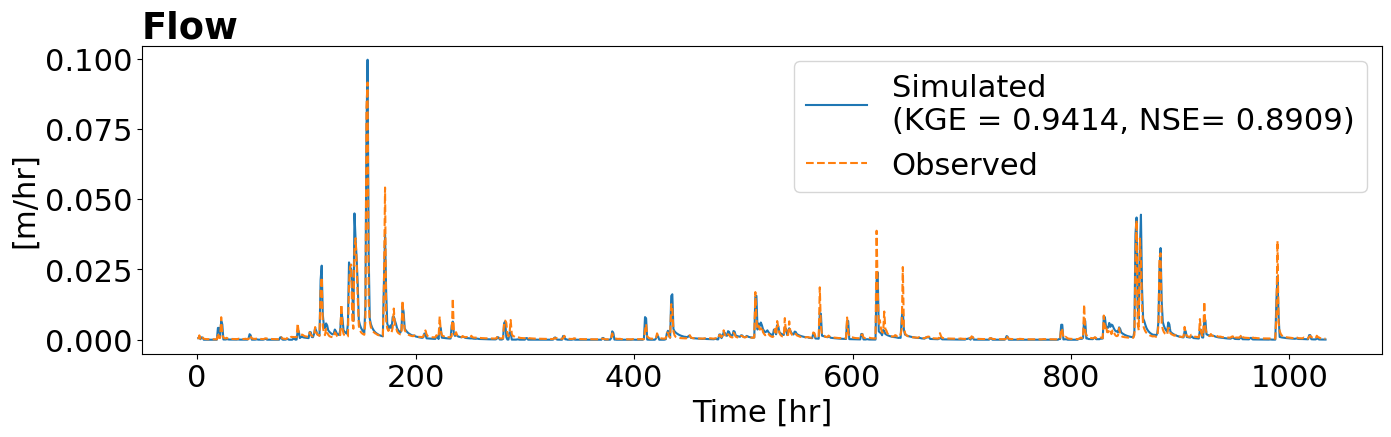

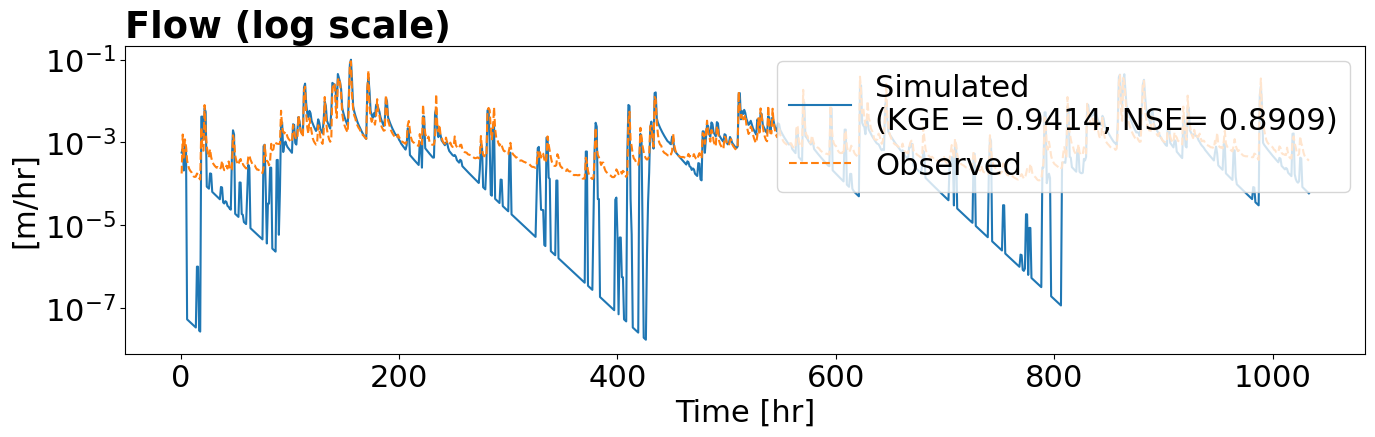

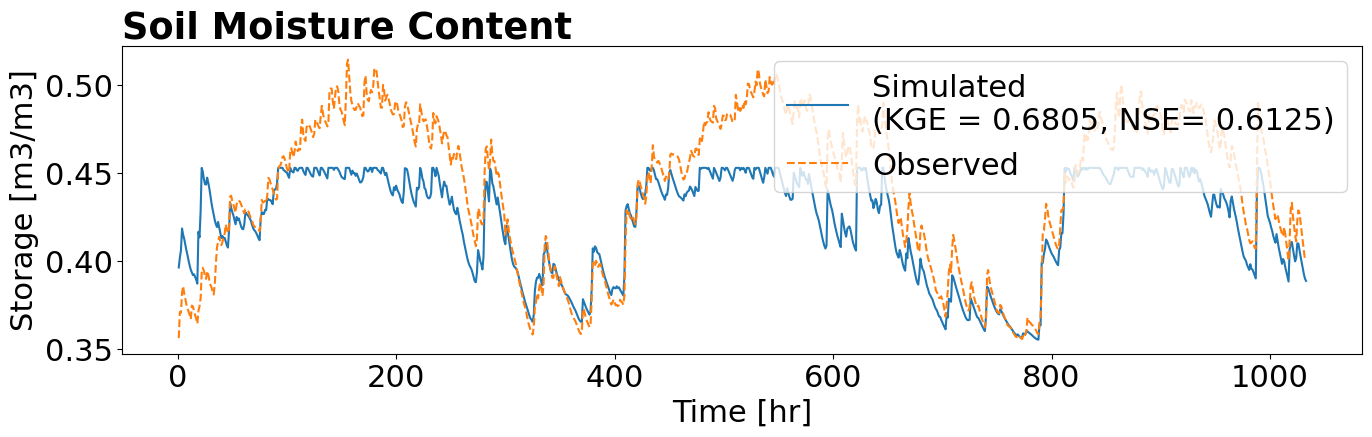

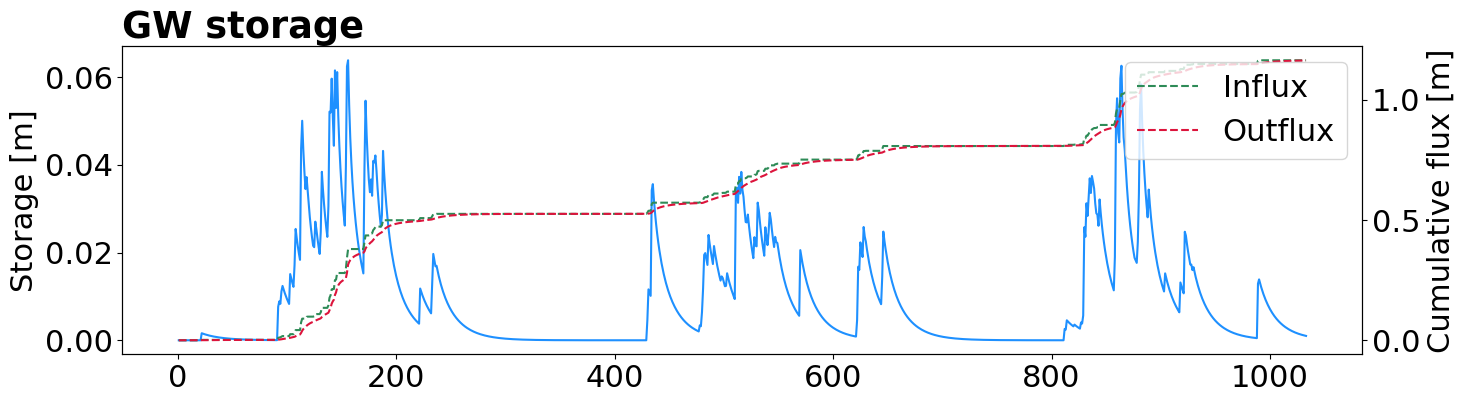

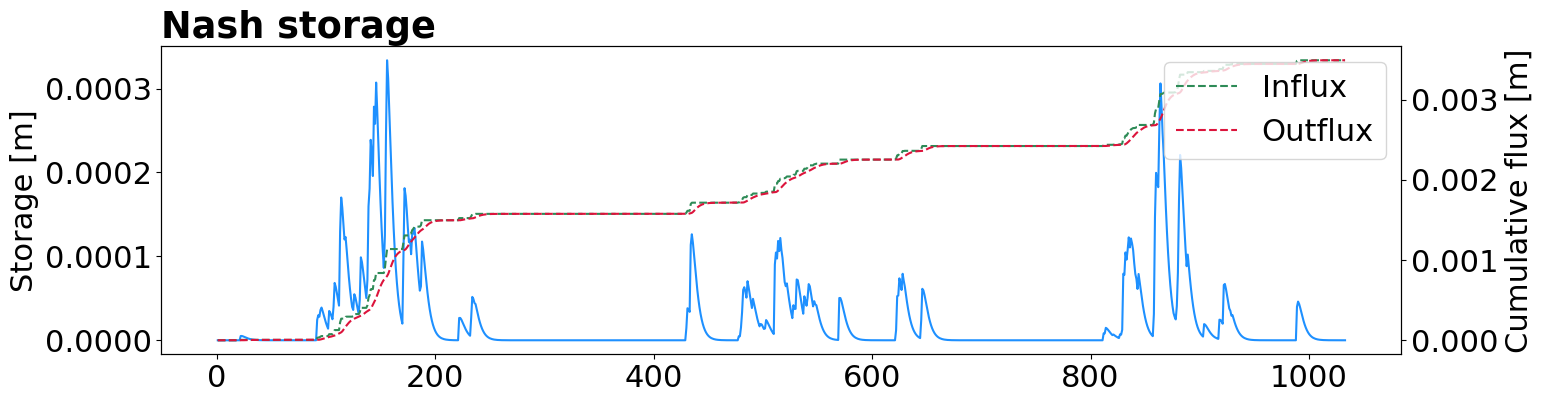

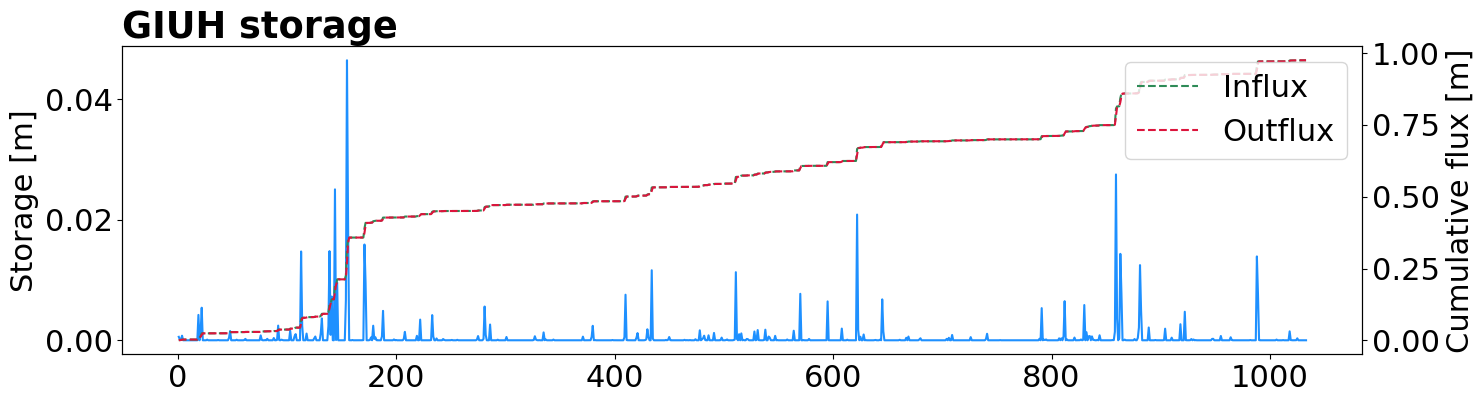

(      Soil Moisture Content
 0                  0.352933
 1                  0.356116
 2                  0.370902
 3                  0.370510
 4                  0.382052
 ...                     ...
 1290               0.471891
 1291               0.459832
 1292               0.465779
 1293               0.467198
 1294               0.457467
 
 [1295 rows x 1 columns],
       Soil Moisture Content
 0                  0.384365
 1                  0.396223
 2                  0.401777
 3                  0.406007
 4                  0.418388
 ...                     ...
 1290               0.452817
 1291               0.452086
 1292               0.452822
 1293               0.452260
 1294               0.450695
 
 [1295 rows x 1 columns])

In [86]:
# Run the CFE based on the config file
cfe_instance = BMI_CFE(temporary_config_file)
cfe_instance.initialize()
sim0 = cfe_instance.run_unit_test(plot=True,
    print_fluxes=True,
    plot_lims=list(range(1, 1034)),
    warm_up=True,
    warmup_offset=400,
    warmup_iteration=10
    )
obs0 = cfe_instance.load_unit_test_data()

# Get the results
var_name = 'Soil Moisture Content'
sim = sim0[["Time", var_name]].copy()
sim["Time"] = pd.to_datetime(sim["Time"], format="%Y-%m-%d")  # Works specifically for CFE

# Get the comparison data
obs = obs0[["Time", var_name]].copy()
obs["Time"] = pd.to_datetime(obs["Time"], format="%Y-%m-%d") 
# if study_site == "Mahurangi":
#     obs["Time"] = pd.to_datetime(obs["Time"], format="%m/%d/%Y %H:%M")  # Works specifically for Mahurangi data
# elif study_site == "LittleWashita":
#     obs["Time"] = pd.to_datetime(obs["Time"], format="%Y-%m-%d %H:%M:%S")  # works for Little ashita
# # obs["Time"] = pd.to_datetime(obs["Time"], format="%d-%m-%Y %H:%M:%S")

# Merge observed and simulated timeseries
df = pd.merge_asof(sim, obs, on="Time")

sim_synced = pd.DataFrame()
obs_synced = pd.DataFrame()
sim_synced[var_name] = df[var_name + "_x"].copy()
obs_synced[var_name] = df[var_name + "_y"].copy()

obs_synced, sim_synced

# Run seasonal signature

In [87]:
# Evaluate using seasonal soil moisture signature
sig_obs = SMSig(
    t=df["Time"].to_numpy(),
    sm=obs_synced[var_name].to_numpy(),
    plot_results=False,
)

seasonal_cycle = pd.read_csv(os.path.join(data_directory, "seasonal_cycle.csv"), parse_dates=['start_date', 'end_date'])

_parameter_config = os.path.join(data_directory, "seasonal_transition_config.json")
with open(_parameter_config, "r") as config_file:
    config = json.load(config_file)

season_trans_obs = sig_obs.calc_seasontrans(seasonal_cycle=seasonal_cycle, parameter_config=config)

sig_sim = SMSig(
    t=df["Time"].to_numpy(),
    sm=sim_synced[var_name].to_numpy(),
    plot_results=False,
)
season_trans_sim = sig_sim.calc_seasontrans(seasonal_cycle=seasonal_cycle, parameter_config=config)

# Get the deviations in seasonal transition dates between simulated and observed timeseries
diff = season_trans_sim - season_trans_obs
metric_value = abs(np.nanmean(diff, axis=0))
print(diff)
print(metric_value)



[[ 14.98930041 -64.13921581   2.58335802  -0.71979418]
 [  4.51625907 -15.62419617   5.6840255  -10.94765246]
 [-18.61625496 -18.61841207 -10.08377522  -6.13255551]]
[ 0.29643484 32.79394135  0.6054639   5.93333405]


# Load evaluation metrics

In [88]:
result_run = pd.read_csv(evaluation_metrics_path)
KGESM_for_the_run = result_run['KGE on Soil'][result_run["run_id"]==run_id].values[0]
print(KGESM_for_the_run)
result_run.head()

0.6804672740395277


,run_id,NSE on Flow,NSE on Soil,KGE on Flow,KGE on Soil,SeasonTrans of Soil dry2wet_start,SeasonTrans of Soil dry2wet_end,SeasonTrans of Soil wet2dry_start,SeasonTrans of Soil wet2dry_end,SeasonTrans of Soil dry2wet_start_raw,SeasonTrans of Soil dry2wet_end_raw,SeasonTrans of Soil wet2dry_start_raw,SeasonTrans of Soil wet2dry_end_raw
0,0,0.870583,-0.116197,0.879833,0.723320,0.898833,32.207192,0.077867,1.788701,"[15.947310891002417, 5.507696024607867, -18.75...","[-62.58391141379252, -14.955658408813179, -19....","[3.553183412645012, 5.564178702421486, -9.3509...","[2.839305623434484, -7.19964348943904, -1.0057..."
1,1,0.784071,-7.086928,0.335623,-0.319040,21.711614,96.308875,17.219010,113.377990,"[-13.825433687772602, -8.905949115287513, -42....","[-135.70040052058175, -70.78930102428421, -82....","[-24.075628217775375, -24.444016533903778, -3....","[-130.62747594481334, -97.83051315555349, -111..."
2,2,0.742028,-1.650655,0.783288,0.794262,2.027438,30.647320,0.391725,8.624781,"[18.15436767693609, 6.544598508160561, -18.616...","[-60.39012540364638, -10.609820154961199, -20....","[3.6848616492934525, 4.674633755348623, -7.184...","[17.2484363601543, 1.0754332607612014, 7.55047..."
3,3,0.869110,0.677258,0.873533,0.816237,2.029368,30.500882,0.682203,4.121407,"[17.889151433017105, 6.2895186031237245, -18.0...","[-60.24108660873026, -11.23238810757175, -20.0...","[4.616347371600568, 5.564206396695226, -8.1339...","[7.981033302843571, -2.0500190486200154, 6.433..."
4,4,0.754053,-26.885436,0.352326,-0.384969,23.712712,98.289620,16.228027,112.387019,"[-15.823993223719299, -10.903661520686, -44.41...","[-137.68036749307066, -72.75958036025986, -84....","[-23.088874944485724, -23.444051386788487, -2....","[-129.64352019689977, -96.82443387899548, -110..."


# Plot the results

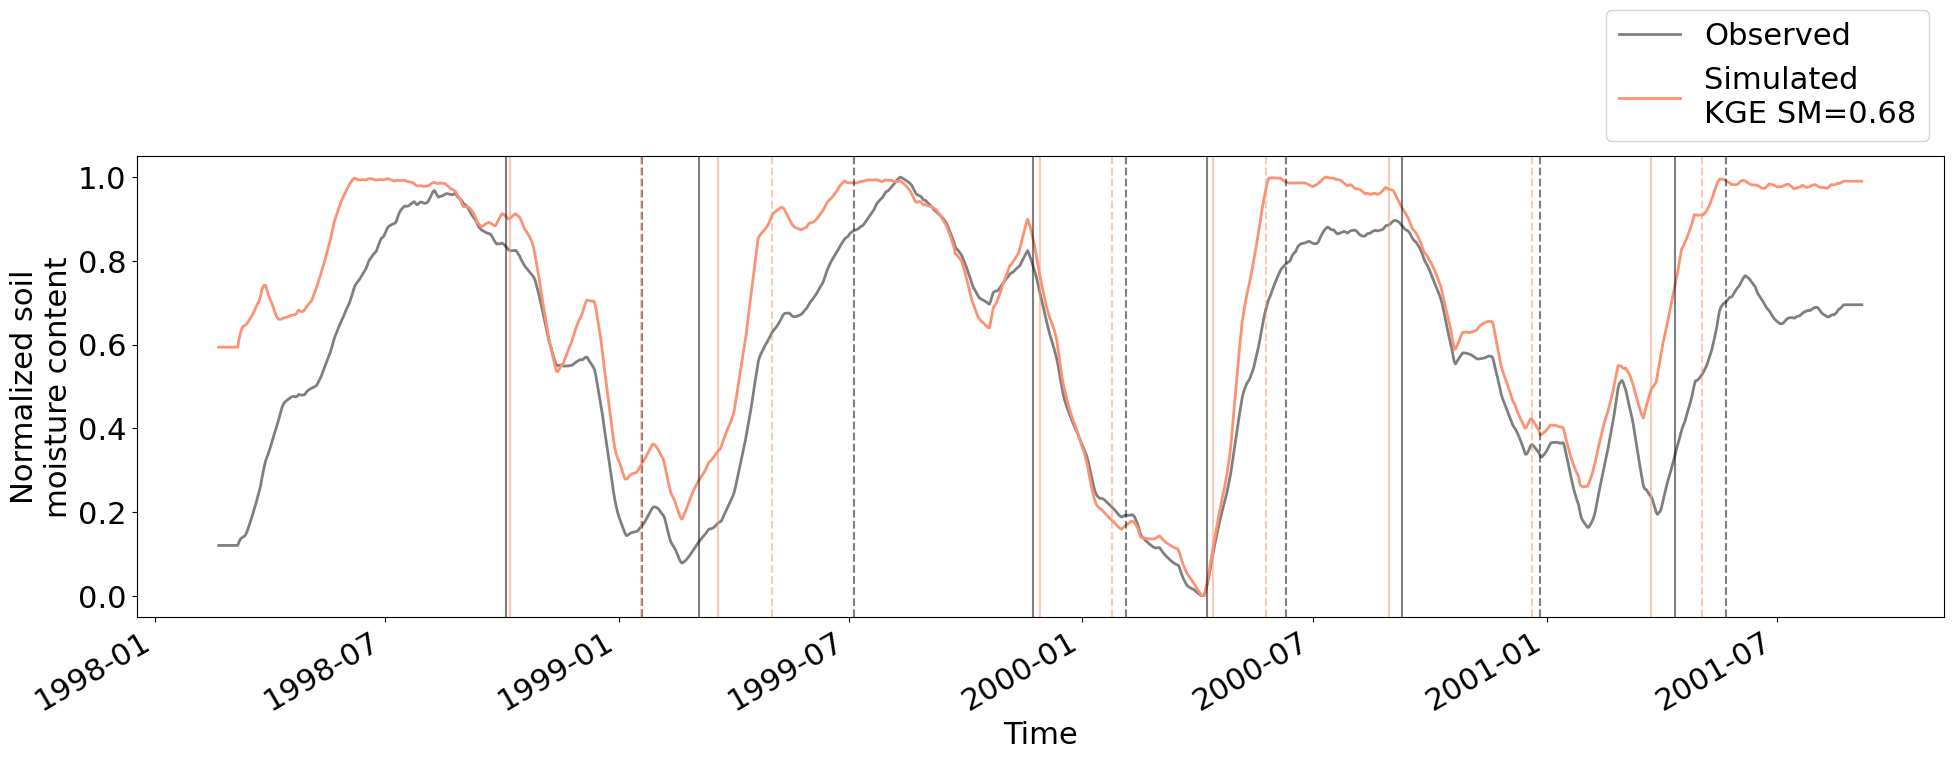

In [89]:
# Relative values of SM 
# Plot out the results
df_obs = obs_synced
df_sim = sim_synced
obs_label = 'Observed'
sim_label = f'Simulated\nKGE SM={KGESM_for_the_run:.2f}'
obs_color = 'k'
sim_color = '#fc9272'
y_label = 'Volumetric Soil Moisture Content [m^3/m^3]'
title = 'Soil moisture and seasonal transition signatures'
fn = 'timeseries.pdf'

f2 = plt.figure(figsize=(20, 8))
ax3 = f2.add_subplot()
plt.rc('font', size=22)
x_obs = sig_obs.tt.index
y_obs = (sig_obs.tt.values-min(sig_obs.tt.values))/(max(sig_obs.tt.values)-min(sig_obs.tt.values))
x_sim = sig_sim.tt.index
y_sim = (sig_sim.tt.values-min(sig_sim.tt.values))/(max(sig_sim.tt.values)-min(sig_sim.tt.values))
xlim_start = 0 #60
xlim_end = len(x_obs) #-60
ax3.plot(x_obs[xlim_start:xlim_end], y_obs[xlim_start:xlim_end], alpha=0.5, label=obs_label, color=obs_color, linewidth=2)
ax3.plot(x_sim[xlim_start:xlim_end], y_sim[xlim_start:xlim_end], alpha=1, label=sim_label, color=sim_color, linewidth=2)

import numpy as np
from datetime import datetime, timedelta
def julian_to_datetime(jd):
    try:
        return datetime(1, 1, 1) + timedelta(days=jd - 1721425)
    except Exception as e:
        # Return np.nan if there's an error
        return np.nan

stard_dates_jd = np.concatenate([season_trans_obs[:, 0], season_trans_obs[:, 2]])
start_dates_obs = [julian_to_datetime(jd) for jd in stard_dates_jd]
end_dates_jd = np.concatenate([season_trans_obs[:, 1], season_trans_obs[:, 3]])
end_dates_obs = [julian_to_datetime(jd) for jd in end_dates_jd]

stard_dates_jd_sim = np.concatenate([season_trans_sim[:, 0], season_trans_sim[:, 2]])
start_dates_sim = [julian_to_datetime(jd) for jd in stard_dates_jd_sim]
end_dates_jd_sim = np.concatenate([season_trans_sim[:, 1], season_trans_sim[:, 3]])
end_dates_sim = [julian_to_datetime(jd) for jd in end_dates_jd_sim]

for i in range(len(start_dates_obs)):
    ax3.axvline(x=start_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_obs)):
    ax3.axvline(x=end_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='--')
for i in range(len(start_dates_sim)):
    ax3.axvline(x=start_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_sim)):
    ax3.axvline(x=end_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='--')
ax3.set_xlabel('Time')
from datetime import datetime
ax3.set_ylabel('Normalized soil\nmoisture content')
# ax3.set_title(title)
ax3.legend(loc='lower right', bbox_to_anchor=(1,1))
plt.tight_layout()
f2.autofmt_xdate()
f2.savefig(os.path.join(out_path, fn), dpi=600, bbox_inches='tight')

In [90]:
start_dates_obs

[datetime.datetime(1999, 3, 5, 7, 48, 58, 313077),
 datetime.datetime(2000, 4, 8, 9, 44, 55, 649229),
 datetime.datetime(2001, 4, 11, 21, 42, 21, 637713),
 datetime.datetime(1998, 10, 4, 13, 37, 51, 46771),
 datetime.datetime(1999, 11, 22, 22, 27, 34, 78402),
 datetime.datetime(2000, 9, 8, 15, 12, 25, 70592)]

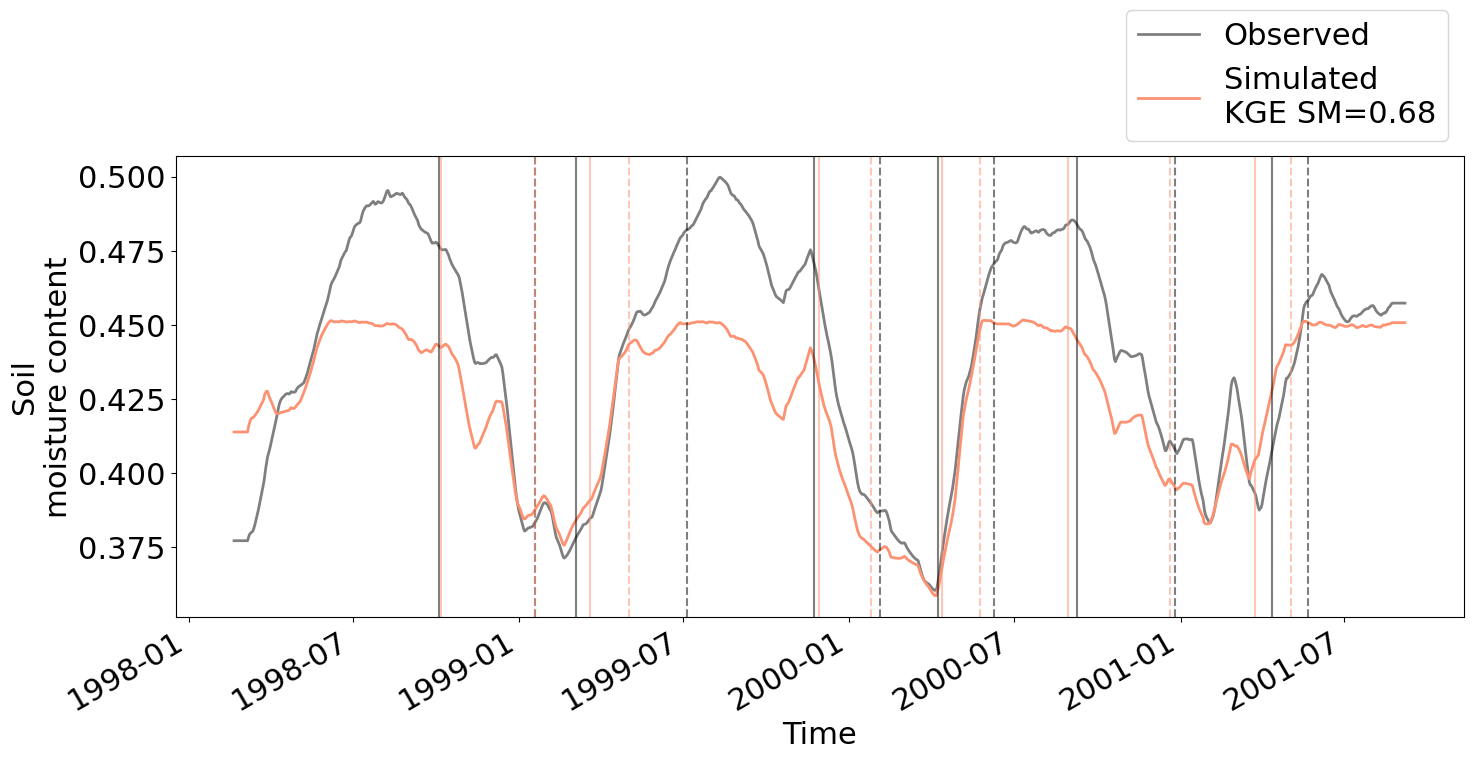

In [91]:
# Relative values of SM 
# Plot out the results
df_obs = obs_synced
df_sim = sim_synced
obs_label = 'Observed'
sim_label = f'Simulated\nKGE SM={KGESM_for_the_run:.2f}'
obs_color = 'k'
sim_color = '#fc9272'
y_label = 'Volumetric Soil Moisture Content [m^3/m^3]'
title = 'Soil moisture and seasonal transition signatures'
fn = 'timeseries.pdf'

f2 = plt.figure(figsize=(15, 8))
ax3 = f2.add_subplot()
plt.rc('font', size=22)
x_obs = sig_obs.tt.index
y_obs = sig_obs.tt.values
x_sim = sig_sim.tt.index
y_sim = sig_sim.tt.values
xlim_start = 0
xlim_end = len(x_obs)
ax3.plot(x_obs[xlim_start:xlim_end], y_obs[xlim_start:xlim_end], alpha=0.5, label=obs_label, color=obs_color, linewidth=2)
ax3.plot(x_sim[xlim_start:xlim_end], y_sim[xlim_start:xlim_end], alpha=1, label=sim_label, color=sim_color, linewidth=2)
for i in range(len(start_dates_obs)):
    ax3.axvline(x=start_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_obs)):
    ax3.axvline(x=end_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='--')
for i in range(len(start_dates_sim)):
    ax3.axvline(x=start_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_sim)):
    ax3.axvline(x=end_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='--')
ax3.set_xlabel('Time')
from datetime import datetime
ax3.set_ylabel('Soil\nmoisture content')
# ax3.set_ylim([0.30, 0.65])
# ax3.set_xlim(datetime(1998, 1,1), datetime(2001, 9, 30))
ax3.legend(loc='lower right', bbox_to_anchor=(1,1))
plt.tight_layout()
f2.autofmt_xdate()
f2.savefig(os.path.join(out_path, fn), dpi=600, bbox_inches='tight')

sig_sim.tt.to_csv(os.path.join(out_path, 'simulated.csv'))
sig_obs.tt.to_csv(os.path.join(out_path, 'observed.csv'))